In [1]:
from google.colab import drive
from google.colab.patches import cv2_imshow
drive.mount('/content/drive')
path = '/content/drive/MyDrive/cv_playground/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preprocess

In [2]:
import os
import cv2
import numpy as np

In [3]:
img = cv2.imread(path+'data/em/downsampled/images/train-volume00.jpg', cv2.IMREAD_GRAYSCALE)
lbl = cv2.imread(path+'data/em/downsampled/labels/train-labels00.jpg', cv2.IMREAD_GRAYSCALE)

[[122 128 138 ... 162 153 153]
 [131 138 142 ... 158 144 156]
 [112 140 146 ... 158 153 180]
 ...
 [196 188 165 ... 162 119 118]
 [165 168 151 ... 187 159 119]
 [155 159 155 ... 210 180 149]]


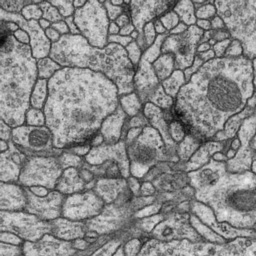

In [4]:
print(img)
cv2_imshow(img)

In [5]:
images = []
labels = []

for img_file, lbl_file in zip(sorted(os.listdir(path+'data/em/downsampled/images')), 
                 sorted(os.listdir(path+'data/em/downsampled/labels'))):
  
  img = cv2.imread(os.path.join(path+'data/em/downsampled/images',img_file), cv2.IMREAD_GRAYSCALE)
  lbl = cv2.imread(os.path.join(path+'data/em/downsampled/labels',lbl_file), cv2.IMREAD_GRAYSCALE)

  images.append(img)
  labels.append(lbl)

  # flip
  for flipcode in [-1,0,1]:
    img2 = cv2.flip(img, flipcode)
    lbl2 = cv2.flip(lbl, flipcode)
    images.append(img2)
    labels.append(lbl2)

In [6]:
images = np.array(images, dtype=float).reshape(-1, 256, 256, 1) / 255.0
labels = np.round_(np.array(labels, dtype=float).reshape(-1, 256, 256, 1) / 255.0)

images.shape

(120, 256, 256, 1)

In [7]:
# brightness
# blurring
# noising
# saturation?

# Train

In [8]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers

In [9]:
images = tf.convert_to_tensor(images)
labels = tf.convert_to_tensor(labels)

In [22]:
class MyModel(tf.keras.Model):
  def __init__(self):
    super().__init__()

    self.dropout = layers.Dropout(0.1)

    self.conv1 = tf.keras.Sequential([
        layers.Conv2D(64, 3, activation='ReLU'),
        layers.Conv2D(64, 3, activation='ReLU'),
    ])
    self.conv2 = tf.keras.Sequential([
        layers.MaxPool2D(pool_size=(2, 2)),
        layers.Conv2D(128, 3, activation='ReLU'),
        layers.Conv2D(128, 3, activation='ReLU'),
        layers.Conv2D(128, 3, activation='ReLU'),
    ])
    self.conv3 = tf.keras.Sequential([
        layers.MaxPool2D(pool_size=(2, 2)),
        layers.Conv2D(256, 3, activation='ReLU'),
        layers.Conv2D(256, 3, activation='ReLU'),
        layers.Conv2D(512, 3, activation='ReLU'),
    ])

    self.bottom = tf.keras.Sequential([
        layers.MaxPool2D(pool_size=(2, 2)),
        layers.Conv2D(1024, 3, activation='ReLU'),
        layers.Conv2DTranspose(512, 3, activation='ReLU'),
        layers.UpSampling2D(size=(2,2))
    ])

    self.deconv1 = tf.keras.Sequential([
        layers.Conv2DTranspose(256, 3, activation='ReLU'),
        layers.Conv2DTranspose(256, 3, activation='ReLU'),
        layers.Conv2DTranspose(256, 3, activation='ReLU'),
        layers.UpSampling2D(size=(2,2))
    ])
    self.deconv2 = tf.keras.Sequential([
        layers.Conv2D(128, 3, activation='ReLU'),
        layers.Conv2D(128, 3, activation='ReLU'),
        layers.UpSampling2D(size=(2,2))
    ])

    self.last = tf.keras.Sequential([
        layers.Conv2D(64, 3, activation='ReLU', padding='same'),
        layers.Conv2D(2, 1, activation='sigmoid'),
    ])

  def call(self, X, training=False):

      X0 = X
      X = tf.pad(X, tf.constant([[0,0], [12, 12], [12, 12], [0,0]]), 'REFLECT')
      X = self.dropout(X)

      X = self.conv1(X)
      #print(X1.shape)
      X2 = self.conv2(X)
      #print(X2.shape)
      X3 = self.conv3(X2)
      #print(X3.shape)

      X = self.bottom(X3)
      #print(X.shape)

      #print(1)
      X = tf.concat([X, X3], 3)
      #print(X.shape)
      X = self.deconv1(X)
      #print(X.shape)
      
      #print(2)
      X = tf.concat([X, X2], 3)
      #print(X.shape)
      X = self.deconv2(X)
      #print(X.shape)

      #print(3)
      X = tf.concat([X, X0], 3)
      #print(X.shape)
      X = self.last(X)
      return X

In [27]:
nn = MyModel()
nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, name='Adam',), loss='SparseCategoricalCrossentropy')
nn(images[0:1]).shape

TensorShape([1, 256, 256, 2])

In [28]:
nn.summary()

Model: "my_model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_4 (Dropout)         multiple                  0         
                                                                 
 sequential_27 (Sequential)  (1, 276, 276, 64)         37568     
                                                                 
 sequential_28 (Sequential)  (1, 132, 132, 128)        369024    
                                                                 
 sequential_29 (Sequential)  (1, 60, 60, 512)          2065408   
                                                                 
 sequential_30 (Sequential)  (1, 60, 60, 512)          9438720   
                                                                 
 sequential_31 (Sequential)  (1, 132, 132, 256)        3539712   
                                                                 
 sequential_32 (Sequential)  (1, 256, 256, 128)        5

In [29]:
nn(images[0:1])

<tf.Tensor: shape=(1, 256, 256, 2), dtype=float32, numpy=
array([[[[0.48796788, 0.50305444],
         [0.47492674, 0.49754193],
         [0.4749349 , 0.49729854],
         ...,
         [0.4671153 , 0.49552757],
         [0.47000954, 0.49676588],
         [0.47532198, 0.50081843]],

        [[0.48594314, 0.5077552 ],
         [0.46901378, 0.5050945 ],
         [0.4678924 , 0.5047211 ],
         ...,
         [0.45595732, 0.5049126 ],
         [0.46015242, 0.5052037 ],
         [0.46738505, 0.4994205 ]],

        [[0.48678854, 0.5065284 ],
         [0.47023875, 0.50592387],
         [0.46893334, 0.5061585 ],
         ...,
         [0.45475614, 0.5044667 ],
         [0.45824814, 0.5044943 ],
         [0.46555084, 0.4990479 ]],

        ...,

        [[0.4808425 , 0.511344  ],
         [0.45469114, 0.50763583],
         [0.45617235, 0.5055138 ],
         ...,
         [0.45478058, 0.5029879 ],
         [0.46120223, 0.500018  ],
         [0.47385967, 0.49764016]],

        [[0.48220956, 0.

In [30]:
nn.fit(x=images, y=labels, shuffle=True, batch_size=16, epochs=50, verbose='auto');

Epoch 1/50
8/8 [==============================] - 7s 668ms/step - loss: 7.6987
Epoch 2/50
8/8 [==============================] - 5s 663ms/step - loss: 0.5587
Epoch 3/50
8/8 [==============================] - 5s 664ms/step - loss: 0.4995
Epoch 4/50
8/8 [==============================] - 5s 669ms/step - loss: 0.4843
Epoch 5/50
8/8 [==============================] - 5s 669ms/step - loss: 0.4730
Epoch 6/50
8/8 [==============================] - 5s 672ms/step - loss: 0.4592
Epoch 7/50
8/8 [==============================] - 5s 675ms/step - loss: 0.4413
Epoch 8/50
8/8 [==============================] - 5s 678ms/step - loss: 0.4068
Epoch 9/50
8/8 [==============================] - 5s 682ms/step - loss: 0.3855
Epoch 10/50
8/8 [==============================] - 6s 686ms/step - loss: 0.3627
Epoch 11/50
8/8 [==============================] - 6s 689ms/step - loss: 0.3372
Epoch 12/50
8/8 [==============================] - 6s 691ms/step - loss: 0.3245
Epoch 13/50
8/8 [==============================] 

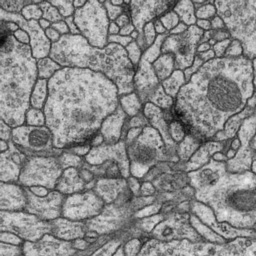

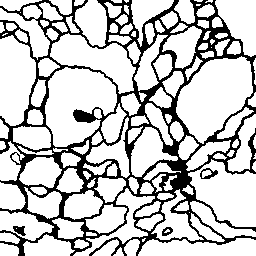

In [31]:
cv2_imshow(images[0:1].numpy().reshape(256, 256)*255)
cv2_imshow(labels[0:1].numpy().reshape(256, 256)*255)

In [32]:
y = np.argmax(nn(images[0:1]).numpy().reshape(256, 256, 2), axis=2)

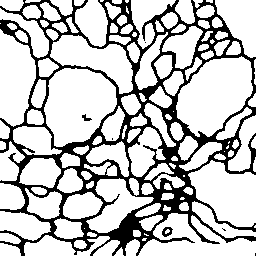

In [33]:
cv2_imshow(y*255)